In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print(tf.__version__)

2.4.0


In [4]:
import pandas as pd
import os

## Preprocessing

In [9]:
train_dataset = pd.read_excel('C:/Users/Sajjad/Documents/coding/internship/deepfore/train_dataset.xlsx')
train_dataset

,Unnamed: 0,File,Target
0,0,G:/Coding/internship/dataset/extracted_faces/a...,FAKE
1,1,G:/Coding/internship/dataset/extracted_faces/a...,FAKE
2,2,G:/Coding/internship/dataset/extracted_faces/a...,FAKE
3,3,G:/Coding/internship/dataset/extracted_faces/a...,FAKE
4,4,G:/Coding/internship/dataset/extracted_faces/a...,FAKE
...,...,...,...
37570,37570,G:/Coding/internship/dataset/extracted_faces/g...,REAL
37571,37571,G:/Coding/internship/dataset/extracted_faces/g...,REAL
37572,37572,G:/Coding/internship/dataset/extracted_faces/g...,REAL
37573,37573,G:/Coding/internship/dataset/extracted_faces/g...,REAL


## Conversion of categorical column to numerical column

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [11]:
Y = train_dataset['Target'].values

In [12]:
Y

array(['FAKE', 'FAKE', 'FAKE', ..., 'REAL', 'REAL', 'REAL'], dtype=object)

In [9]:
y_labelencoder = LabelEncoder()
Y = y_labelencoder.fit_transform(Y)
print(Y)

[0 0 0 ... 1 1 1]


In [10]:
Y = Y.reshape(-1,1)
Y

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [11]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(),[0])], remainder='passthrough')
Y = ct.fit_transform(Y)
print(Y)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [12]:
import cv2

images = []
data_path = 'G:/Coding/internship/dataset/extracted_faces'

with tf.device('/GPU:0'):
    for root, dirs, files in os.walk('G:/Coding/internship/dataset/extracted_faces'):
        for f in files:
            img = cv2.imread(data_path + '/' + str(f))
            images.append(img)

In [13]:
images

[array([[[ 78,  93, 102],
         [ 72,  87,  96],
         [ 69,  86,  95],
         ...,
         [ 91, 118,  85],
         [ 95, 119,  87],
         [102, 126,  94]],
 
        [[ 71,  86,  95],
         [ 71,  86,  95],
         [ 77,  94, 103],
         ...,
         [ 88, 115,  82],
         [ 93, 117,  85],
         [100, 124,  92]],
 
        [[ 68,  83,  92],
         [ 72,  87,  96],
         [ 88, 103, 112],
         ...,
         [ 86, 113,  80],
         [ 91, 115,  83],
         [ 97, 121,  89]],
 
        ...,
 
        [[ 12,  17,  15],
         [ 12,  17,  15],
         [ 12,  17,  16],
         ...,
         [142, 198, 209],
         [141, 196, 205],
         [137, 192, 201]],
 
        [[ 12,  17,  15],
         [ 12,  17,  15],
         [ 12,  17,  16],
         ...,
         [144, 199, 208],
         [142, 195, 205],
         [139, 192, 202]],
 
        [[ 12,  17,  15],
         [ 12,  17,  15],
         [ 12,  17,  16],
         ...,
         [145, 200, 209],
  

In [14]:
import numpy as np

with tf.device('/GPU:0'):
    images = np.array(images)

    images = images.astype('float32') / 255.0
    images.shape

In [16]:
import pickle
with tf.device('/GPU:0'):
    with open("6-4_image_array", "wb") as fp:
        pickle.dump(images, fp)

In [12]:
import pickle
with open("image_255_array", "rb") as fp:   # Unpickling
     b = pickle.load(fp)

## train-val-split

In [18]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

with tf.device('/GPU:0'):
    images, Y = shuffle(images, Y, random_state=1)
    train_x, val_x, train_y, val_y = train_test_split(images, Y, test_size=0.2, random_state=415)
    #inpect the shape of the training and testing.
    print(train_x.shape)
    print(train_y.shape)
    print(val_x.shape)
    print(val_y.shape)

(30060, 224, 224, 3)
(30060, 2)
(7515, 224, 224, 3)
(7515, 2)


## Efficient Net implementation - Training the model

In [5]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

NUM_CLASSES = 2
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)


inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# Using model without transfer learning

outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

In [20]:
import tensorflow as tf

checkpoint_path = 'G:/Coding/internship/training_weights/training_weight2/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
 
with tf.device('/GPU:0'):
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )
    model.summary()
    gpu_performance =model.fit(train_x, train_y, epochs=30, callbacks=[cp_callback], verbose=2)
    gpu_performance

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 2)                 4052133   
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/30
940/940 - 299s - loss: 0.8660 - accuracy: 0.7578

Epoch 00001: saving model to G:/Coding/internship/training_weights/training_weight2\cp.ckpt
Epoch 2/30
940/940 - 185s - loss: 0.3272 - accuracy: 0.8893

Epoch 00002: saving model to G:/Coding/internship/training_weights/training_weight2\cp.ckpt
Epoch 3/30
940/940 - 185s - loss: 0.1567 - accuracy: 0.9483

Epoch 00003: saving model to G:/Coding/internship/training_weights/training_weight2\cp.ckpt
Epoch 4/30
940/940 - 185s - loss: 0.1541 - accura

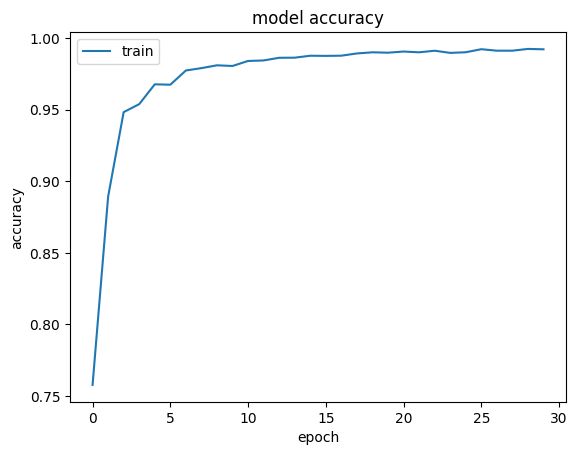

In [21]:
import matplotlib.pyplot as plt


def plot_hist(gpu_performance):
    plt.plot(gpu_performance.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(gpu_performance)

In [22]:
preds = model.evaluate(val_x, val_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

235/235 [==============================] - 18s 73ms/step - loss: 0.0412 - accuracy: 0.9875
Loss = 0.04122623801231384
Test Accuracy = 0.9874916672706604


In [6]:
checkpoint_path = 'G:/Coding/internship/training_weights/training_weight2/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 2)                 4052133   
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________


In [7]:
model.load_weights(checkpoint_path)

## Testing the model on test dataset

In [19]:
import cv2
import numpy as np

t_images = []
data_path = 'G:/Coding/internship/dataset/extracted_test_faces'


for root, dirs, files in os.walk('G:/Coding/internship/dataset/extracted_test_faces'):
    for f in files:
        img = cv2.imread(data_path + '/' + str(f))
        t_images.append(img)
      
        
       
       


In [20]:
t_images = np.array(t_images)

t_images = t_images.astype('float32') / 255.0
t_images.shape

(29993, 224, 224, 3)

In [21]:
import pickle
with open("t_image255_array", "wb") as fp:   #Pickling
    pickle.dump(t_images, fp)

In [8]:
import pickle
with tf.device('/GPU:0'):
    with open("t_image255_array", "rb") as fp:   # Unpickling
        c = pickle.load(fp)

In [9]:
c.shape

(29993, 224, 224, 3)

In [10]:
with tf.device('/GPU:0'):
    preds=model.predict(c)
    preds

In [11]:
preds

array([[6.3105595e-05, 9.9993694e-01],
       [6.3105595e-05, 9.9993694e-01],
       [6.3105595e-05, 9.9993694e-01],
       ...,
       [6.6334046e-02, 9.3366599e-01],
       [6.6334046e-02, 9.3366599e-01],
       [6.6334046e-02, 9.3366599e-01]], dtype=float32)

In [12]:
test_df = pd.read_excel('G:/Coding/internship/dataset/test_labels.xlsx')

In [13]:
test_df

,fake
0,fake
1,fake
2,fake
3,fake
4,fake
...,...
29989,fake
29990,fake
29991,fake
29992,fake


In [14]:
test_y = test_df['fake'].values
test_y

array(['fake', 'fake', 'fake', ..., 'fake', 'fake', 'real'], dtype=object)

In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
y_labelencoder = LabelEncoder()
test_y = y_labelencoder.fit_transform(test_y)
print(test_y)

[0 0 0 ... 0 0 1]


In [17]:
test_y = test_y.reshape(-1,1)

In [18]:
test_y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [19]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(),[0])], remainder='passthrough')
test_y = ct.fit_transform(test_y)
print(test_y)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [20]:
test_y.shape

(29994, 2)

In [21]:
test_y = test_y[0:29993]

In [22]:
test_y.shape

(29993, 2)

In [23]:
tf.config.run_functions_eagerly(True)

In [24]:
with tf.device('/GPU:0'):
    eval = model.evaluate(c, test_y)
    print ("Loss = " + str(eval[0]))
    print ("Test Accuracy = " + str(eval[1]))

C:\Users\Sajjad\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


938/938 [==============================] - 59s 61ms/step - loss: 1.3241 - accuracy: 0.6257
Loss = 1.3234604597091675
Test Accuracy = 0.6124762296676636


## Testing the model on sample images

Input image shape: (1, 224, 224, 3)


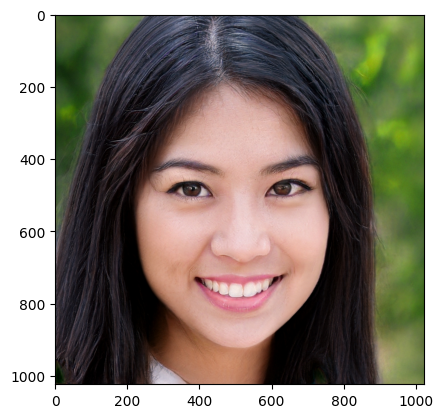

In [25]:
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import cv2
import numpy as np

img_path = 'G:/Coding/internship/dataset/sample images for testing/f1.jpeg'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

In [26]:
preds=model.predict(x)
preds  

C:\Users\Sajjad\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


array([[2.0313227e-37, 1.0000000e+00]], dtype=float32)

Input image shape: (1, 224, 224, 3)


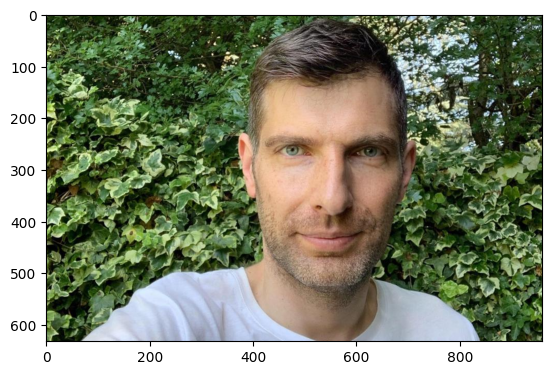

In [27]:
img_path = 'G:/Coding/internship/dataset/sample images for testing/1.jpg'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x1 = np.expand_dims(img, axis=0)
x1 = preprocess_input(x1)

print('Input image shape:', x1.shape)

my_image = imread(img_path)
imshow(my_image)

In [28]:
preds=model.predict(x1)
preds  

array([[0., 1.]], dtype=float32)

Input image shape: (1, 224, 224, 3)


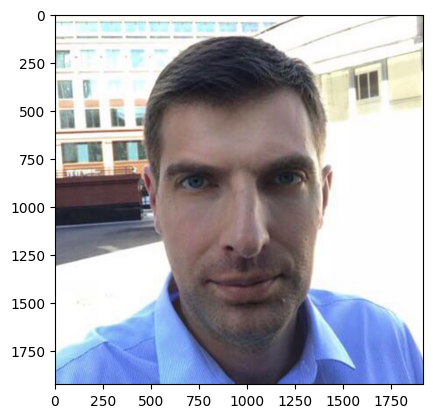

In [29]:
img_path = 'G:/Coding/internship/dataset/sample images for testing/2.jpg'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x2 = np.expand_dims(img, axis=0)
x2 = preprocess_input(x2)

print('Input image shape:', x2.shape)

my_image = imread(img_path)
imshow(my_image)

In [30]:
preds=model.predict(x2)
preds  

array([[0., 1.]], dtype=float32)

Input image shape: (1, 224, 224, 3)


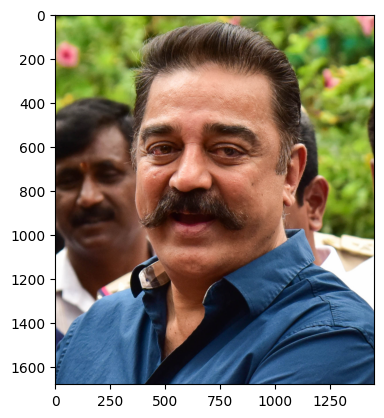

In [31]:
img_path = 'G:/Coding/internship/dataset/sample images for testing/r1.jpg'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x3 = np.expand_dims(img, axis=0)
x3 = preprocess_input(x3)

print('Input image shape:', x3.shape)

my_image = imread(img_path)
imshow(my_image)

In [32]:
preds=model.predict(x3)
preds  

array([[0., 1.]], dtype=float32)

Input image shape: (1, 224, 224, 3)


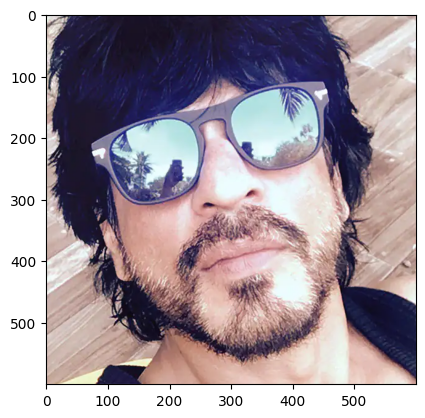

In [33]:
img_path = 'G:/Coding/internship/dataset/sample images for testing/r2.webp'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x4 = np.expand_dims(img, axis=0)
x4 = preprocess_input(x4)

print('Input image shape:', x4.shape)

my_image = imread(img_path)
imshow(my_image)

In [34]:
preds=model.predict(x4)
preds  

array([[0., 1.]], dtype=float32)

Input image shape: (1, 224, 224, 3)


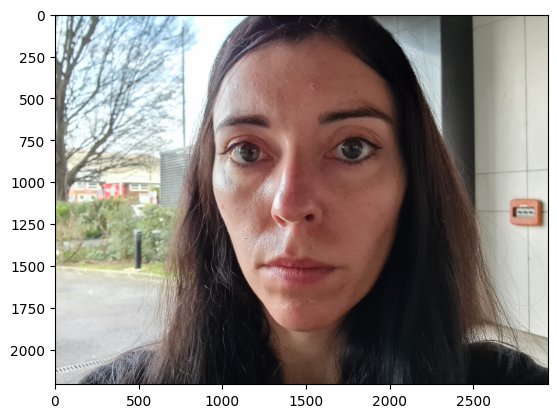

In [35]:
img_path = 'G:/Coding/internship/dataset/sample images for testing/r3.jpg'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x5 = np.expand_dims(img, axis=0)
x5 = preprocess_input(x5)

print('Input image shape:', x5.shape)

my_image = imread(img_path)
imshow(my_image)

In [36]:
preds=model.predict(x5)
preds 

array([[0., 1.]], dtype=float32)

Input image shape: (1, 224, 224, 3)


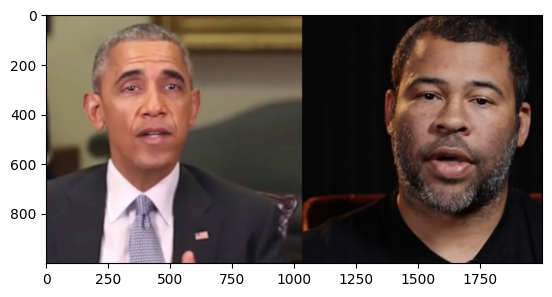

In [39]:
img_path = 'G:/Coding/internship/dataset/sample images for testing/f3.webp'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x5 = np.expand_dims(img, axis=0)
x5 = preprocess_input(x5)

print('Input image shape:', x5.shape)

my_image = imread(img_path)
imshow(my_image)

In [40]:
preds=model.predict(x5)
preds 

array([[1., 0.]], dtype=float32)